This project was my Master's thesis! . It is not completely calibrated as I changed some parameters but, I will upload the calibrated one in the future using a different MODFLOW version

In [1]:
from IPython.display import Image

Below is the communities of Tacherting and Wajon, in southern Germany. They are sorrounded by two streams: The Alz river and the Alz channel, a channel built to hydropower. The communities of this areas have been affected by raises in the groundwater. Therefore the importance of building a couple GW-SW model

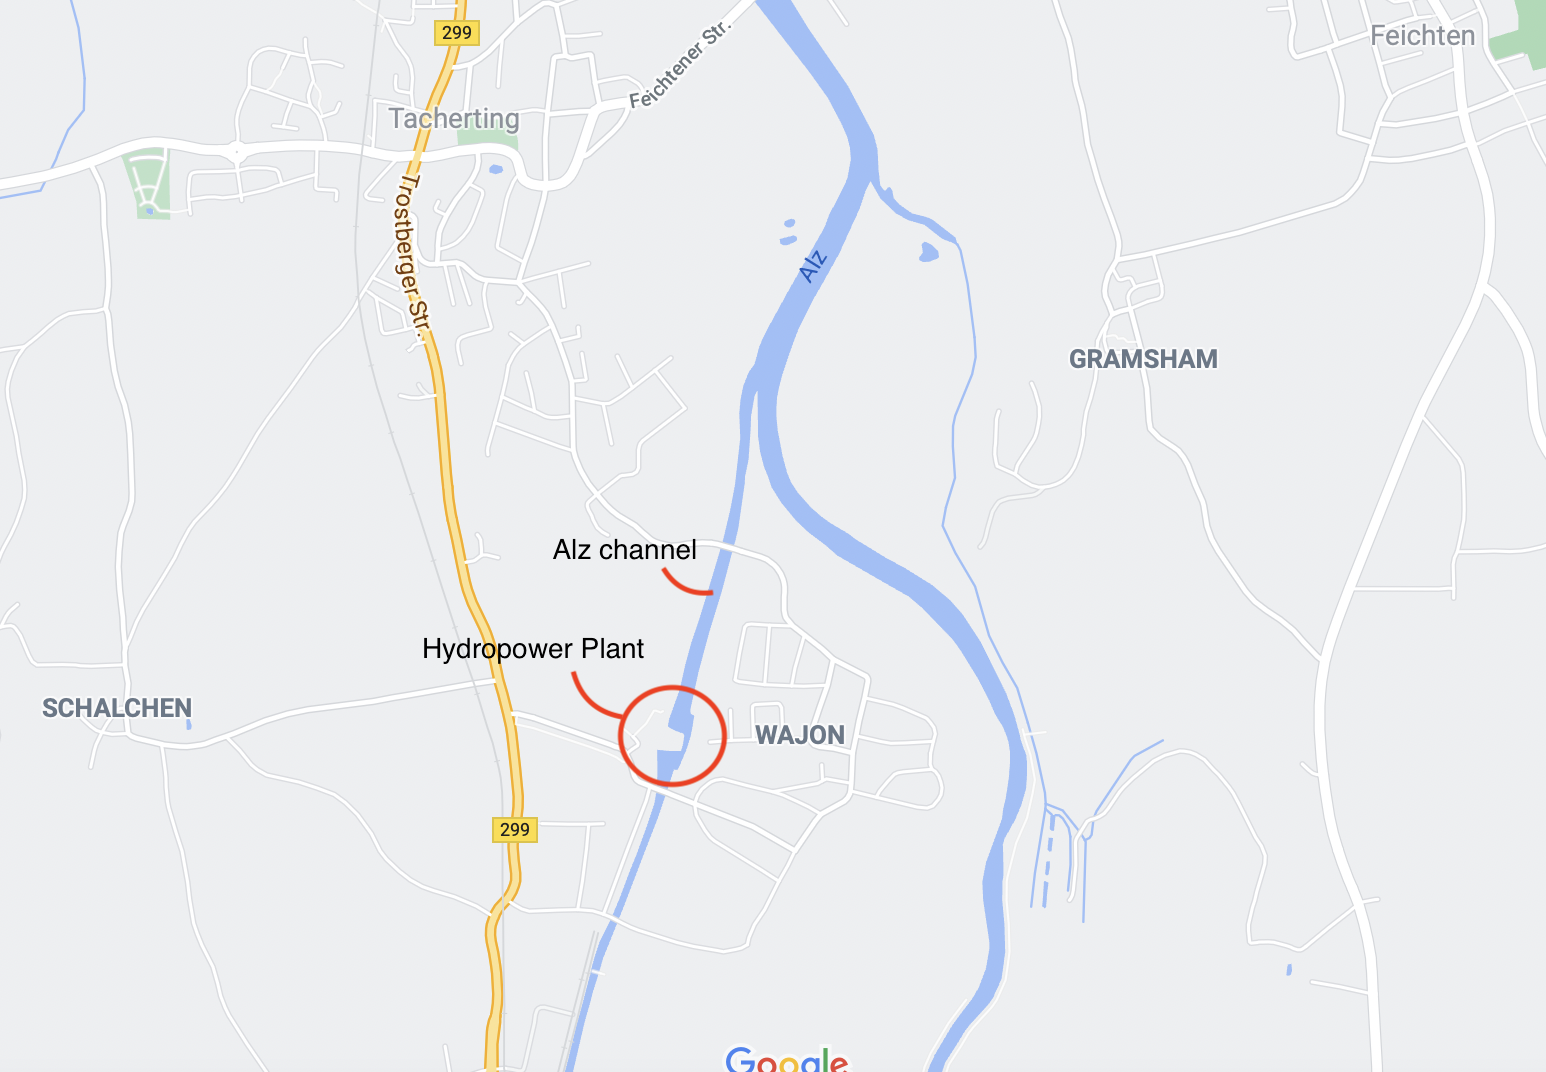

In [2]:
Image("../Data/location.png", width=500)

# Study area delimitation

Delimitation was made base on geological units and the location of the wells available to calibrate the model. The Alz channel upstream the powerplant is considered to be not coneected to the aquifer (or at leaast in a veeeery limited magnitude) as it is revested with concrete.

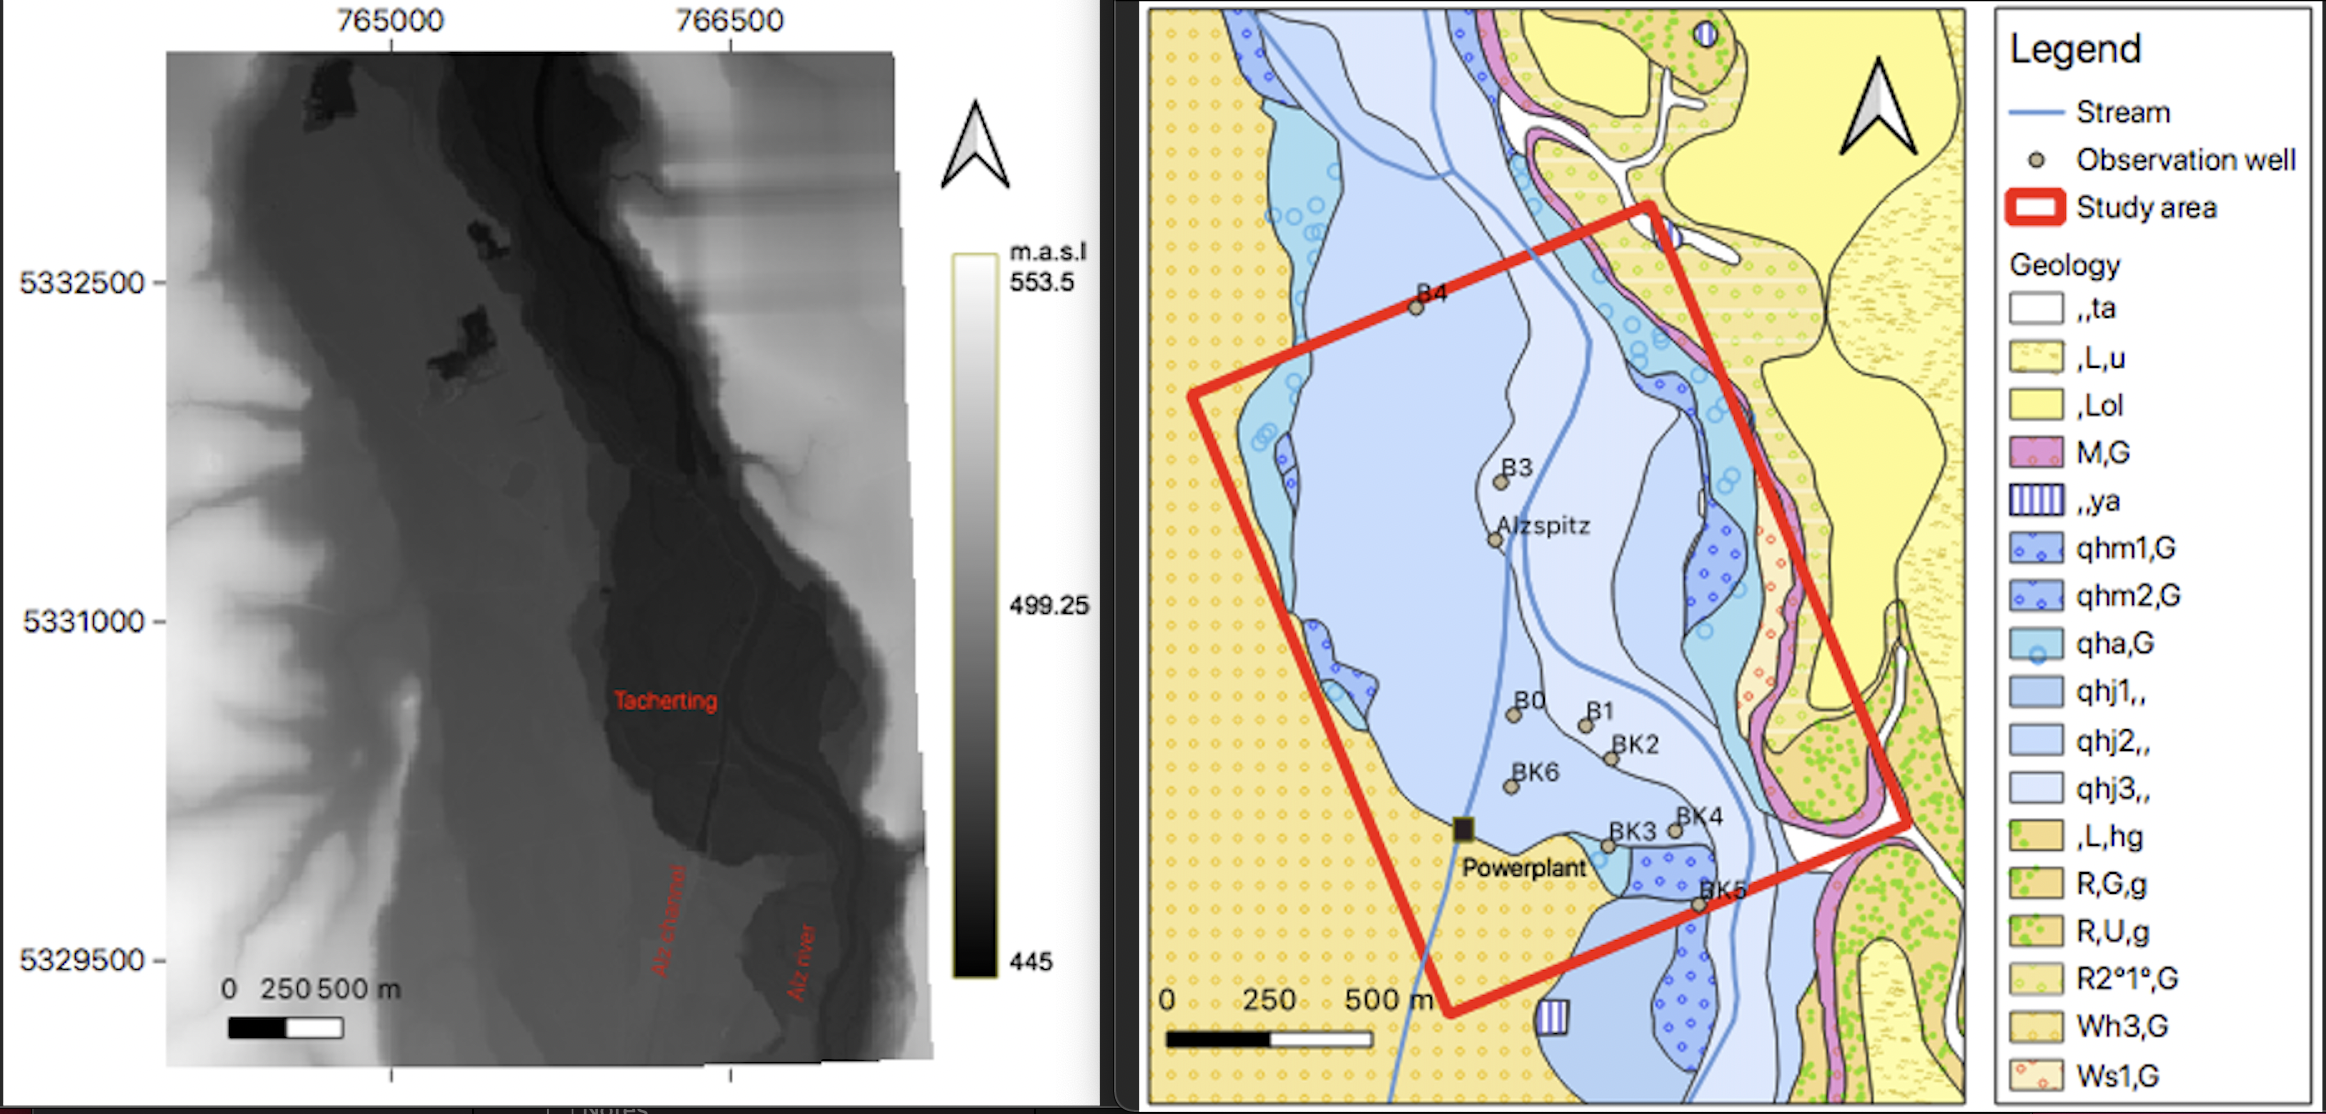

In [3]:
Image("../Data/delimitation.png", width=1000)

# Model setup

In [4]:
from osgeo import gdal
import shapely
import shapefile
from shapely.geometry import shape
import flopy
import matplotlib.pyplot as plt
import numpy as np
from flopy.utils.gridintersect import GridIntersect
import pandas as pd

In [5]:
def load(file_name):
    start_date = '2013-09-01'  # yyyy-mm-dd
    end_date = '2014-02-28'
    df = pd.read_csv(f'../Data/{file_name}.csv')
    df.time = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('time', inplace=True)
    df = df[start_date: end_date]
    df = df.append(df.iloc[0])  # appends the first measurament to consider a first steady state
    df.sort_index(inplace=True)
    return df

In [6]:
discharges = load('discharges') # flow discharges
gw_obs = load('gw_obs') # Groundwater observation wells in the area ( there are 10 in total)
weather = load('weather') # daily ET and precipitation rates 

Here i display some of the input parameters of the model. In this case, the discarges from the river and the alz channel as well as the ET and precipitation and finally, the observation from two observation wells located in the area. In total the are 10 wells. 

Text(0, 0.5, 'm.a.s.l')

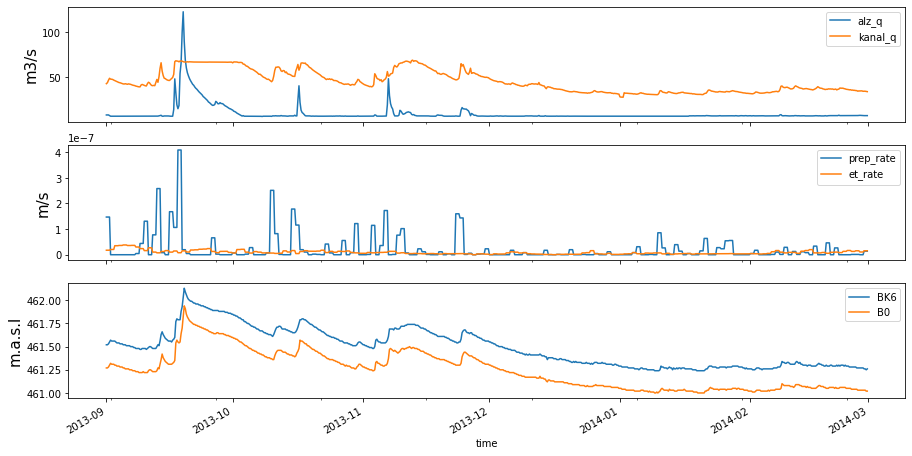

In [7]:
fig, axs = plt.subplots(3, figsize=((15,8)),sharex=True)
discharges.plot(ax=axs[0])
axs[0].set_ylabel('m3/s', fontsize=15)
weather.plot(ax=axs[1])
axs[1].set_ylabel('m/s', fontsize=15)
gw_obs.loc[:, ['BK6', 'B0']].plot(ax=axs[2])
axs[2].set_ylabel('m.a.s.l', fontsize=15)

In [8]:
study_area_shape = shapefile.Reader("../Data/Shapefiles/area.shp")
shp=study_area_shape.shapeRecords()[0]
coor = shp.shape.__geo_interface__  
coor_list = coor['coordinates'][0]

In [9]:
coor_list

[(766821.8848767015, 5331543.2484039655),
 (767451.7404189334, 5330029.645129007),
 (766331.00376693, 5329563.273125639),
 (765701.148224698, 5331076.876400597),
 (766821.8848767015, 5331543.2484039655)]

Here I initiallize some spatio-temporal variables.

In [10]:
dem_ds=gdal.Open("../Data/Shapefiles/DEM_study_area.tif")
demdata = dem_ds.GetRasterBand(1).ReadAsArray()
#demdata[demdata<0]= 469.54498

nlay=3 # number of layers
ztop = demdata.copy() # upper most layer is represented by the DEM
ztop[ztop<0] = 469.54498 # removing no data from DEM
bottom=[ztop-6, ztop-25, ztop-50]
nrow=dem_ds.RasterYSize
ncol=dem_ds.RasterXSize

time_resolution = 6 # hours
nper = len(discharges)  # number of stress periods
perlen = np.ones(nper, dtype=int)*time_resolution*60*60  # length of stress period in seconds
perlen[0] = 1  # lengh of steady state
nstp = np.ones(nper, dtype=int)  # number of timesteps per stress period 
nstp[0] = 1
steady = np.zeros(nper, dtype=bool)  # transient periods 
steady[0] = True  # initial steady state

In [11]:
name= 'Tacherting'
mf = flopy.modflow.Modflow(name, exe_name='../Executables/mfnwt', model_ws='Output/', version='mfnwt')

I chose mwnwt since i am going to work with precipitation and ET but, it should also work with other versions. 

In [12]:
dis = flopy.modflow.ModflowDis(mf,nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=5, delc=5, # DEM resolution 5 m
                               top=ztop, botm= bottom, 
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady, itmuni=1, lenuni=2)
mf.modelgrid.set_coord_info(xoff=coor_list[3][0], yoff=coor_list[2][1], epsg=25832)

# Define active space

There is a code in the geology shapefile to identify each Geologic unit. In this loop, every cell of the model is interected and assigned the code into a matrix

In [13]:
geology = np.ones((dem_ds.RasterYSize , dem_ds.RasterXSize), dtype=int)


geo_shp= shapefile.Reader('../Data/Shapefiles/geo_codes.shp')

for i in range(len(geo_shp)):
    cells=[]
    feature= geo_shp.shapeRecords()[i]
    coordinates = feature.shape.__geo_interface__
    # object geometry
    shp_geom = shape(coordinates)
    ix = GridIntersect(mf.modelgrid)
    cells.append(ix.intersect(shp_geom))
       
    for j in cells[0].cellids:
        x,y = j
        geology[x][y]= feature.record.codigo


/opt/miniconda3/envs/gdallib/lib/python3.9/site-packages/flopy/utils/gridintersect.py:1326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ipoly in intersect:


In [14]:
# removes no data points from DEM
ibounddata = demdata.copy()
ibounddata[ibounddata>0] = 1
ibounddata[ibounddata<0] = 0

act_space = geology*ibounddata # here i remove no data from geology matrix

With next cell i am defining the bottom most layer

In [15]:
Bottm_layer = np.zeros((dem_ds.RasterYSize , dem_ds.RasterXSize), dtype=int)
study_area_shape = shapefile.Reader('../Data/Shapefiles/bottom_layer.shp')

for i in range(len(study_area_shape)):
    cells=[]
    feature= study_area_shape.shapeRecords()[i]
    coordinates = feature.shape.__geo_interface__
    # object geometry
    shp_geom = shape(coordinates)
    ix = GridIntersect(mf.modelgrid,method='structured')
    cells.append(ix.intersect(shp_geom))
       
    for j in cells[0].cellids:
        x,y = j
        Bottm_layer[x][y]= feature.record.active

In [16]:
spc = np.stack((act_space, act_space, Bottm_layer))
spc[spc>1]=1

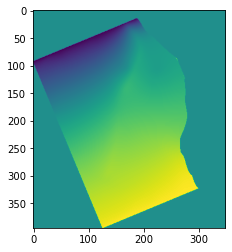

In [17]:
# here i am importing previous results from the model for it to converge faster in the first time-step
starting_head=np.loadtxt(mf.model_ws+'heads.txt')
plt.imshow(starting_head)

In [18]:
bas = flopy.modflow.ModflowBas(mf, ibound=spc, strt=starting_head)

These graphs show the active space of the model 

Text(0.5, 1.0, 'layer 3')

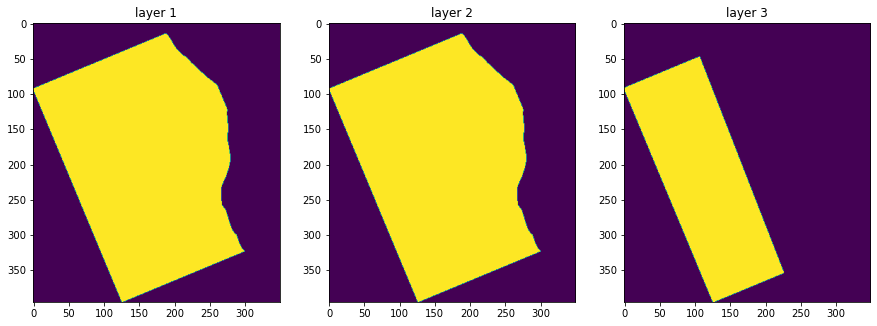

In [19]:
fig, axs = plt.subplots(1,3, figsize=((15,8)),sharex=True)
axs[0].imshow(bas.ibound.array[0])
axs[0].set_title('layer 1')

axs[1].imshow(bas.ibound.array[1])
axs[1].set_title('layer 2')

axs[2].imshow(bas.ibound.array[2])
axs[2].set_title('layer 3')

# UPW 

This package defines the hydraulic conductivity and other properties to each layer

In [20]:
cond = {1: 6.0e-3, 2: 4.5e-3, 3: 4.0e-3, 4: 5.5e-3, 5: 1.2e-2}
vcond = {1: cond[1] / 7.5, 2: cond[2] / 6, 3: cond[3] / 6.25, 4: cond[4] / 5, 5: cond[5] / 9}

ssarray = {}
for i in cond:
    ssarray[i] = 3.5e-5
syarray = {}
for i in cond:
    syarray[i] = 0.18
    
hk = act_space.copy()
vhk = act_space.copy()
ss = act_space.copy()
sy = act_space.copy()

for i in np.unique(act_space):
    if i==0:
        pass  # avoids inactive cells
    else:
        hk = np.where(hk == i, cond[i], hk)
        vhk = np.where(vhk == i, vcond[i], vhk)
        ss = np.where(ss == i, ssarray[i], ss)
        sy = np.where(sy == i, syarray[i], sy)

In [21]:
# second layer
hk = np.stack((hk, ibounddata * cond[5], spc[-1]*cond[5]))  # 6 is the geologic code. See shapefile
vhk = np.stack((vhk, ibounddata * vcond[5], spc[-1]*vcond[5]))
ss = np.stack((ss, ibounddata * ssarray[5], spc[-1]*ssarray[5]))
sy = np.stack((sy, ibounddata * syarray[5], spc[-1]*syarray[5]))

layertype = np.ones(nlay)  # 0= confined ; >0 unconfined
layvka = np.zeros(nlay)  # vhk is defined ; >0 is the ratio

# layer package
upw = flopy.modflow.ModflowUpw(mf, laytyp=layertype, layvka=layvka, hk=hk, vka=vhk, ss=ss, sy=sy)

Now here is the final outcome of the package. Following graphs display the hydraulic conductivity (HK) of every layer. It can be seen that every geologic unit has a different HK

Text(0.5, 1.0, 'layer 3')

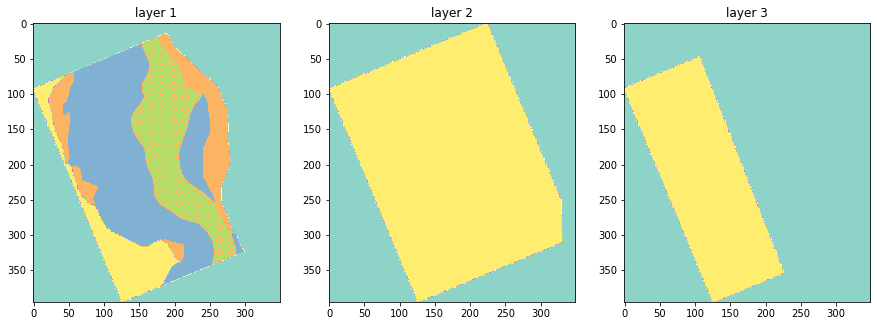

In [22]:
fig, axs = plt.subplots(1,3, figsize=((15,8)),sharex=True)
axs[0].imshow(upw.hk.array[0], cmap=plt.get_cmap('Set3', 10))
axs[0].set_title('layer 1')

axs[1].imshow(upw.hk.array[1],cmap=plt.get_cmap('Set3', 10))
axs[1].set_title('layer 2')

axs[2].imshow(upw.hk.array[2],cmap=plt.get_cmap('Set3', 10))
axs[2].set_title('layer 3')

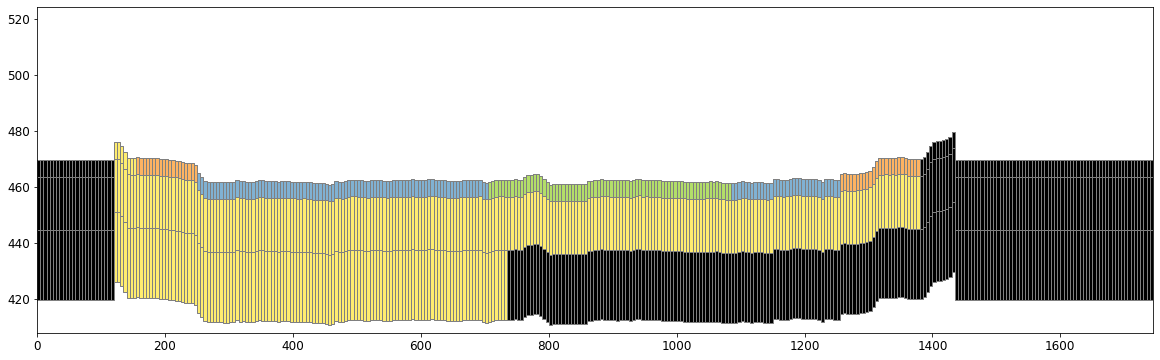

In [23]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 150})
num_colors=10
cmap = plt.get_cmap('Set3', num_colors)
modelxsect.plot_array(mf.upw.hk.array,cmap=cmap)
modelxsect.plot_ibound()
linecollection = modelxsect.plot_grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Stream flow routing package - SFR

This package defines the properties of the stream (stream bed conductivity, flow, water stage, slope and others)

In [24]:
# Cross section geometry 
cross_section = {1: [[0.0 , 3.03, 12.121, 16.162, 23.232, 33.333, 50.505, 54.546], 
                     [2.007, 0.94, 0.089, 0.0, 0.094, 0.122, 0.94, 1.708]],
                 2: [[0.0, 2.0, 4.0, 7.0, 10.0, 14.0, 16.0, 18.0],
                     [5.01, 2.2, 0.1, 0.005, 0.0, 0.1, 2.2, 5.01]],
                 3: [[0.0, 4.04, 6.061, 16.162, 33.333, 49.495, 56.566, 59.596],
                     [1.694, 1.205, 0.418, 0.074, 0.0, 0.071, 0.488, 1.847]]}

channel_geometry_data={}
for i in range(nper): 
    channel_geometry_data[i]= cross_section
    
# Cross section properties
riv = {1: {'chan':0.035,'bank': 0.035,'cond': 1.0E-05, 'thick': 1.0, 'cond2': 2.0E-05, 'elevup': 463.1, 'elevdn': 460.8},
       2: {'chan': 0.035, 'bank': 0.035, 'cond': 7.0E-05, 'thick': 1.0, 'cond2': 7.0E-05, 'elevup': 460.9, 'elevdn': 459.9},
       3: {'chan': 0.035, 'bank': 0.035, 'cond': 3.0E-04, 'thick': 1.0, 'cond2': 3.0E-04, 'elevup': 460.8,'elevdn': 460.2}}

Here is the cross section of the streams. The SFR package defines the water stage based on the discharge and the geometry of these cross sections

Text(0.5, 0, 'Width [m]')

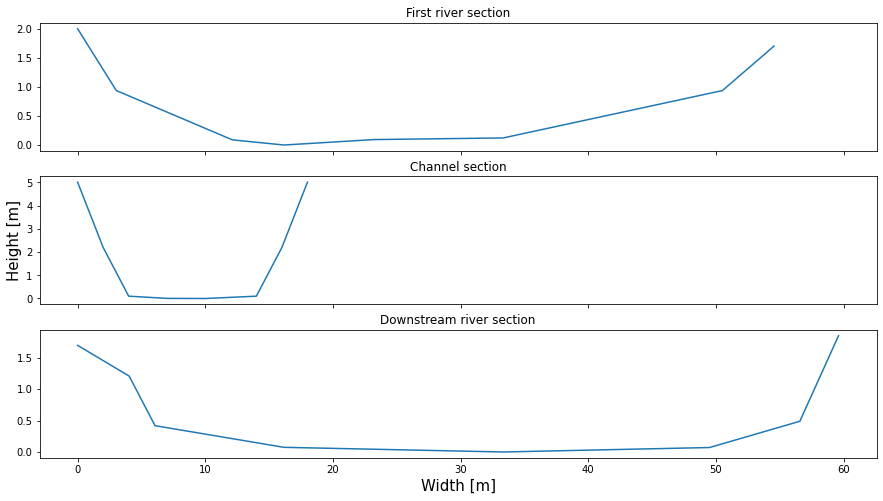

In [25]:
fig, axs = plt.subplots(3, figsize=((15,8)),sharex=True)
axs[0].plot(cross_section[1][0], cross_section[1][1]) 
axs[0].set_title('First river section')
axs[1].plot(cross_section[2][0], cross_section[2][1]) 
axs[1].set_title('Channel section')
axs[1].set_ylabel('Height [m]', fontsize=15)
axs[2].plot(cross_section[3][0], cross_section[3][1]) 
axs[2].set_title('Downstream river section')
axs[2].set_xlabel('Width [m]', fontsize=15)

In [26]:
river_shp = shapefile.Reader('../Data/Shapefiles/rivers.shp')
reach_cells = []
segment_info = []

for i in range(len(river_shp)):
    reach = river_shp.shapeRecords()[i]
    coord = reach.shape.__geo_interface__
    # object geometry
    shp_geom = shape(coord)
    ix = GridIntersect(mf.modelgrid)
    match = ix.intersect(shp_geom)

    if len(match) > 0 and reach.record.iseg > 0:  # excludes rivers outside study area
        for cell in match:
            row_id, col_id = cell.cellids
            length = cell.lengths
            p = reach.record
            # Reach definition
            reach_cells.append([0, row_id, col_id, p.iseg, length, demdata[row_id, col_id]])

        # Segment definition. Properties are defined in shapefile
        segment_info.append([p.iseg, p.icalc, p.outseg, p.iupseg, 0, riv[p.iseg]['chan'], riv[p.iseg]['bank'],  # 4b list ---> 0=flow
                             riv[p.iseg]['cond'], riv[p.iseg]['thick'], riv[p.iseg]['elevup'], 0, p.thts1, p.thti1, p.eps1,  # 6b list -> 0, width1
                             riv[p.iseg]['cond2'], riv[p.iseg]['thick'], riv[p.iseg]['elevdn'], 0, p.thts2, p.thti2, p.eps2])  # 6c

seg_col = ['nseg', 'icalc', 'outseg', 'iupseg', 'flow', 'roughch', 'roughbk',
           'hcond1', 'thickm1', 'elevup', 'width1', 'thts1', 'thti1', 'eps1',
           'hcond2', 'thickm2', 'elevdn', 'width2', 'thts2', 'thti2', 'eps2']
segmentsdf = pd.DataFrame(segment_info, columns=seg_col)
river_cells = pd.DataFrame(reach_cells, columns=['k', 'i', 'j', 'iseg', 'rchlen', 'Top_elev'])

river_cells.sort_values(["iseg", 'i'], ascending=[True, False], inplace=True)
segmentsdf = segmentsdf.sort_values("nseg", ascending=True)
river_cells['ireach'] = 0
river_cells['strtop'] = 0

for seg in range(1, len(segmentsdf) + 1):  # modify to real values of elev
    # numbers the reaches inside the segments
    river_cells.loc[river_cells.iseg == seg, 'ireach'] = np.arange(1, len(river_cells.loc[river_cells.iseg == seg]) + 1)
    # defines the segement's width upstreeam (width1) and downstream(width2). Taken from the xsections
    segmentsdf.loc[segmentsdf.nseg == seg, 'width1'] = cross_section[seg][0][-1]
    segmentsdf.loc[segmentsdf.nseg == seg, 'width2'] = segmentsdf.loc[segmentsdf.nseg == seg, 'width1']

neworder = ['k', 'i', 'j', 'iseg', 'ireach', 'rchlen']
river_cells = river_cells.reindex(columns=neworder)
reach_segment = river_cells.to_records(index=False)

segmentss = {}
for i in range(nper):
    segmentsdf.loc[segmentsdf.nseg == 1, 'flow'] = discharges.alz_q.iloc[i]
    segmentsdf.loc[segmentsdf.nseg == 2, 'flow'] = discharges.kanal_q.iloc[i]
    segmentss[i] = segmentsdf.to_records(index=False)

nstrm = len(reach_segment)  # number of reaches
nss = len(segmentss[0])  # number of segments
# nsfrpar = 0 # number of parameters (not supported)
ipakcb = 1  # flag for writing SFR output to cell-by-cell budget (on unit 53) 53
istcb2 = 81  # flag for writing SFR output to text file 81

sfr = flopy.modflow.ModflowSfr2(mf,
                                nstrm=nstrm,
                                reachinput=True,  # unsaturated flow active
                                nss=nss,
                                isuzn=nlay,
                                isfropt=4,  # Seg are defined with the properties at the edges
                                const=1,  # constant 1= m3/s
                                reach_data=reach_segment,
                                segment_data=segmentss,
                                channel_geometry_data=channel_geometry_data,
                                istcb2=istcb2)

One disadvantage of this MODFLOW version is that the stream segments are constrained to the width of the cell (5m in this case). In contrast, the real width are between 20-60 m . This will likely have effects at small scales

[<AxesSubplot:title={'center':' SFR location stress period 1 layer 1'}>]

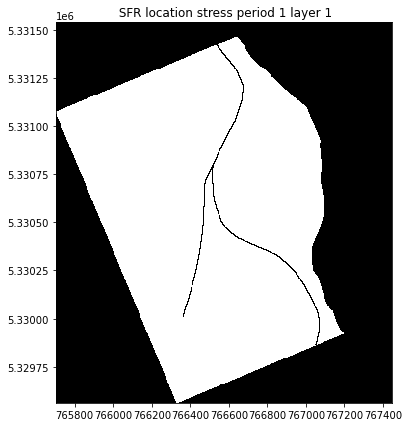

In [27]:
sfr.plot(mflay=0, figsize=(7,7))

# Unsaturated zone flow package - UZF

UZF package includes the evapotranspiration and precipitation processes. This with aim of calculating GW recharges through the unsaturated zone 

In [28]:
""" Here i define active space of the package. Basically eveything but the cells that would correspond 
to the river. So, I won't consider any change in water stage/flow of the river due to precipitation or
evapotranspiration.""" 

# loads the TIF containing the areal extent of the river
river_extent=gdal.Open("../Data/Shapefiles/DEM_no_river.tif")
river_extent_data=river_extent.GetRasterBand(1).ReadAsArray()

uzf_space = act_space.copy()
uzf_space[uzf_space>1]=1
uzf_space = uzf_space * river_extent_data
uzf_space[uzf_space>1]=1

inf = {}
et = {}
for i in range(0, nper):
    if i == 0:
        inf[i] = 0  # weather.rain.iloc[i] #0.0000001
        et[i] = 0
    else:
        inf[i] = weather.prep_rate.iloc[i]  # 0.0000001
        et[i] = weather.et_rate.iloc[i]

uzf = flopy.modflow.ModflowUzf1(mf,
                                nuztop=1,  # land surface is top layer
                                iuzfopt=2,  # 1= VK in UZF package; 2 = VK in LPF package
                                ietflg=1,  # 1 # ET is simulated if >0
                                iuzfbnd=uzf_space,  # uzf_space,
                                finf=inf,  # inf rate
                                pet=et)

The active space is only defined for the first layer

Text(0.5, 1.0, 'Active space')

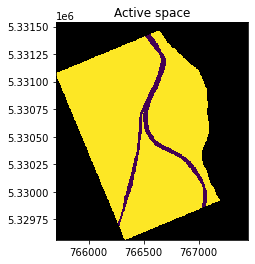

In [29]:
plt.figure()
uzf.iuzfbnd.plot(mflay=0)
plt.title('Active space')

# General head boundary package - GHB

In [30]:
boundaries_shp = shapefile.Reader('../Data/Shapefiles/boundary_lines.shp')
#boundaries_shp = shapefile.Reader('../Data/Shapefiles/Boundaries.shp')

boundaries_cells = {}
[boundaries_cells.setdefault(x, []) for x in range(nper)]

for i in range(len(boundaries_shp)):
    boundary = boundaries_shp.shapeRecords()[i]
    coord = boundary.shape.__geo_interface__
    shp_geom = shape(coord)
    ix = GridIntersect(mf.modelgrid)
    match = ix.intersect(shp_geom)
        
    if boundary.record.boundary=='NORTH':
        for per in range(nper):
            for cell in match.cellids:
                x,y = cell
                boundaries_cells[per].append([nlay-2, x,y, gw_obs.B4.iloc[per], cond[5]*19]) 
    else:
        for per in range(nper):
            for cell in match.cellids:
                x,y = cell
                boundaries_cells[per].append([nlay-2, x, y, gw_obs.BK5.iloc[per], cond[5]*19])

In [31]:
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=boundaries_cells)

# Output control

In [32]:
oc = {(0, 0): ['save head','save budget']} #, 'save_drawdown','save_budget','save ibound']
#oc = {}
for kper in np.arange(1, nper, 361):
    for kstp in range(nstp[kper]):
        oc[(kper, kstp)] = ['save head','save budget']
oc_pak = flopy.modflow.ModflowOc(mf, stress_period_data=oc)

# Observation wells

In [33]:
wells_shp= shapefile.Reader('../Data/Shapefiles/obs_wells.shp')
obs_data= []


for i in range(len(wells_shp)):
    point= wells_shp.shapeRecords()[i]
    coord = point.shape.__geo_interface__
    # object geometry
    shp_geom = shape(coord)
    ix = GridIntersect(mf.modelgrid)
    loc=ix.intersect(shp_geom)
    names = point.record[0]
    row_id, col_id=loc.cellids[0]
    
    #for i in range(1,nper):
    #    measuraments=[(gw_obs.index[i]-gw_obs.index[0]).total_seconds(), gw_obs[f'{name}'][i]]
    measuraments=[[(gw_obs.index[i]-gw_obs.index[0]).total_seconds()+1, gw_obs[f'{names}'][i]] for i in range(1, len(gw_obs))]
    obs = flopy.modflow.HeadObservation(mf, obsname=names, layer=0, row=row_id, column=col_id, time_series_data=measuraments)
    obs_data.append(obs)

hob = flopy.modflow.ModflowHob(mf, iuhobsv=1, obs_data=obs_data)

# Solver and Finally ...model execution!

In [34]:
nwt = flopy.modflow.ModflowNwt(mf)
mf.write_input()

In [35]:
mf.run_model()

FloPy is using the following executable to run the model: /Users/svo/Documents/Projects/Tacherting/Executables/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.2.0 03/01/2020                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: Tacherting.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/10/30 21:17:50

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     5    Time step:

 Solving:  Stress period:    99    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   101    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   102    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   103    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   105    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   106    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   109    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   206    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   207    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   208    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   209    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   210    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   211    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   212    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   213    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   214    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   215    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   216    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   217    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   218    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   313    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   314    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   315    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   316    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   317    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   318    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   319    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   320    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   321    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   322    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   323    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   324    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   325    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   420    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   421    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   422    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   423    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   424    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   425    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   426    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   427    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   428    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   429    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   430    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   431    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   432    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   527    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   528    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   529    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   530    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   531    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   532    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   533    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   534    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   535    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   536    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   537    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   538    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   539    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   634    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   635    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   636    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   637    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   638    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   639    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   640    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   641    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   642    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   643    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   644    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   645    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   646    Time step:     1    Groundwater-Flow Eqn.

(True, [])

# Results!

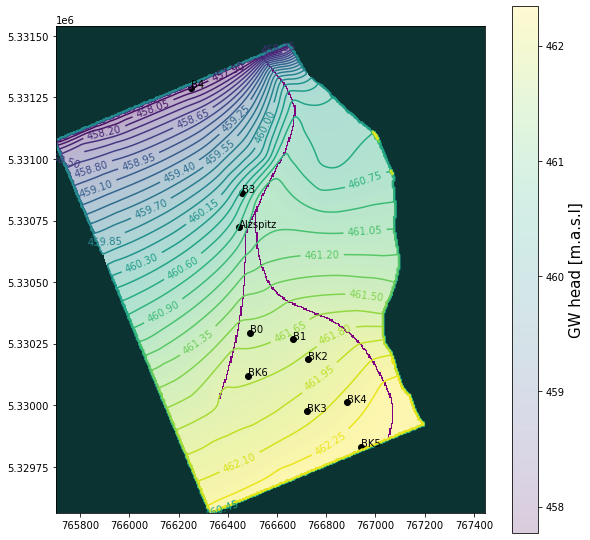

In [36]:
info = flopy.utils.HeadFile(mf.model_ws+'Tacherting.hds', model=mf)
times=info.get_times()
head=info.get_alldata(mflay=1)
time=-1
head[head<0]= (gw_obs.BK5.iloc[time]+gw_obs.B4.iloc[time])/2
head[head>gw_obs.BK5.iloc[time]]=gw_obs.BK5.iloc[time]


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, aspect= 'equal')
modelmap = flopy.plot.PlotMapView(model=mf)
inactive = modelmap.plot_inactive()

contour = modelmap.contour_array(head[time], levels=30, ax=ax)
cell= modelmap.plot_array(head[time], ax=ax, alpha=0.2)

rivers=modelmap.plot_bc('SFR', color='purple')

for i in range(len(wells_shp)):
    nam,x,y=wells_shp.records()[i][0:3]
    ax.scatter(x,y, c='black')
    ax.annotate(nam, (x,y))

ax.clabel(contour)
plt.tight_layout()
cb = plt.colorbar(cell)
cb.set_label(label='GW head [m.a.s.l]', size=15)

In [37]:

hobOut = pd.read_csv(mf.model_ws+'Tacherting.hob.out',delim_whitespace=True)
hobOut.rename(columns={'SIMULATED EQUIVALENT':'Simulated',
                      'OBSERVED VALUE':'Observed',
                      'OBSERVATION NAME':'Piezometer'},inplace=True)
hobOut['Residual'] = hobOut['Simulated'] - hobOut['Observed']

wells=['B0', 'B1', 'B3', 'BK2', 'BK3', 'BK4', 'BK6','Alzspitz']
for well in wells:
    hobOut.loc[hobOut.Piezometer.str.contains(well), 'time']= gw_obs.index[1:]
hobOut.set_index('time', inplace=True)
#test.append(hobOut)

In [38]:
from sklearn.metrics import mean_squared_error, r2_score

def rmse(s, o):
    return np.sqrt(np.mean((s-o)**2))
def NS(s, o):
    return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)
def pc_bias(s, o):
    return 100.0*np.sum(s-o)/np.sum(o)


def oneplotresiduals(df, wells):
    plt.figure(figsize =(15, 7))
    
    values=[]
    for j in range(0, len(wells)):
        filtered = df.loc[df.Piezometer.str.contains(wells[j])]
        rowswithvalue=gw_obs[wells[j]].notnull().sum()
        filtered=filtered[0:rowswithvalue]
        rms = mean_squared_error(filtered.Observed, filtered.Simulated, squared=False)
        rmss= rmse(filtered.Simulated, filtered.Observed)
        r2 = r2_score(filtered.Observed, filtered.Simulated)
        correlation_matrix= np.corrcoef(filtered.Observed,filtered.Simulated)
        correlation_xy = correlation_matrix[0,1]
        bias =pc_bias(filtered.Simulated, filtered.Observed)
        nash=NS(filtered.Simulated, filtered.Observed)
        npr2 = correlation_xy**2
        
        plt.scatter(filtered['Observed'],filtered['Simulated'],label=(f'{wells[j]}----> R2={npr2.round(2)}, RMSE={rmss.round(2)}, NSE={nash.round(2)}, P_BIAS={bias.round(2)}'))

        values.append([filtered['Observed'].min(), filtered['Observed'].max()])
        
 

    values.sort()
    x =np.linspace(values[0][0], values[-1][-1])
    plt.plot(x, x, color='Black')
        
        
    labels= np.round(np.linspace(x[0], x[-1], 5), 2)
    plt.xticks(labels, fontsize=15)
    plt.xlabel('Observed head [m.a.s.l]', fontsize=15)
    plt.yticks(labels, fontsize=15)
    plt.ylabel('Simulated head [m.a.s.l]', fontsize=15)


    plt.legend(fontsize=13,ncol=2, loc="lower center", bbox_to_anchor=(0.5, -0.4))
   # loc="lower center", bbox_to_anchor=(0.5, -0.1

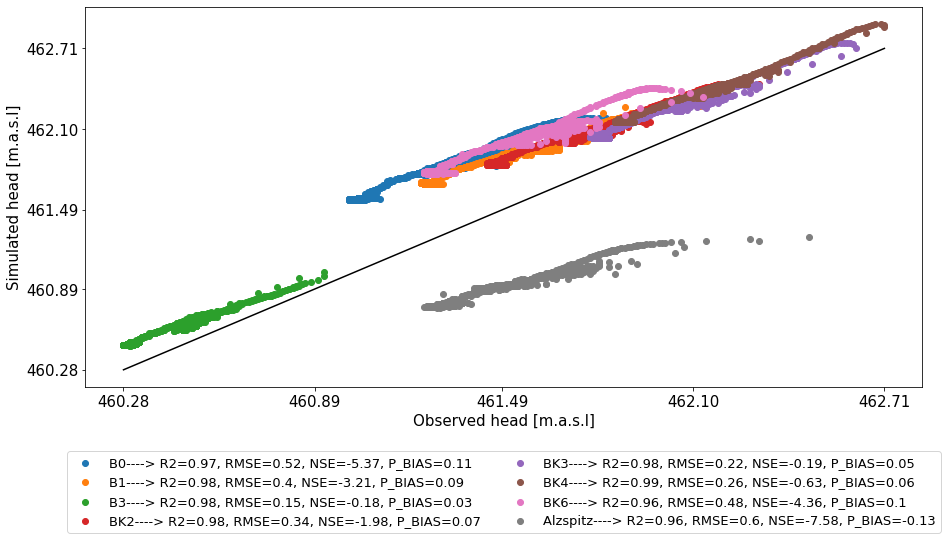

In [39]:
oneplotresiduals(hobOut, wells)

In [40]:
def plotss(df, wells):
    fig, axes = plt.subplots(int(len(wells)/2), 2 , sharex=True, figsize = (50, 40))
    axes = axes.ravel()

    test=df
    for j in range(0, len(wells)):
        filtered = test.loc[test.Piezometer.str.contains(wells[j])]
        rowswithvalue=gw_obs[wells[j]].notnull().sum()
        filtered=filtered[0:rowswithvalue]
        axes[j].set_title(wells[j], fontsize=55)
        filtered.Observed.plot(ax=axes[j], label='Observed', linestyle='dashed',linewidth=3)
        filtered.Simulated.plot(ax=axes[j], label='Simulated', linewidth=3)

        for label in (axes[j].get_yticklabels() + axes[j].get_xticklabels()):
            label.set_fontsize(45)
        axes[j].locator_params(axis="y", nbins=5)



    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=70)
    #fig.legend(handles, ['Observed', '5m grid', '20m grid', 'new '], fontsize=70)
    fig.text(0.03, 0.5, '[m.a.s.l]', ha='center', va='center', rotation='vertical', fontsize=55)
    plt.subplots_adjust(left=0.1, bottom=0.05, right=1, top=.92, wspace=0.12, hspace=0.15)
    plt.locator_params(axis="y", nbins=5)

        

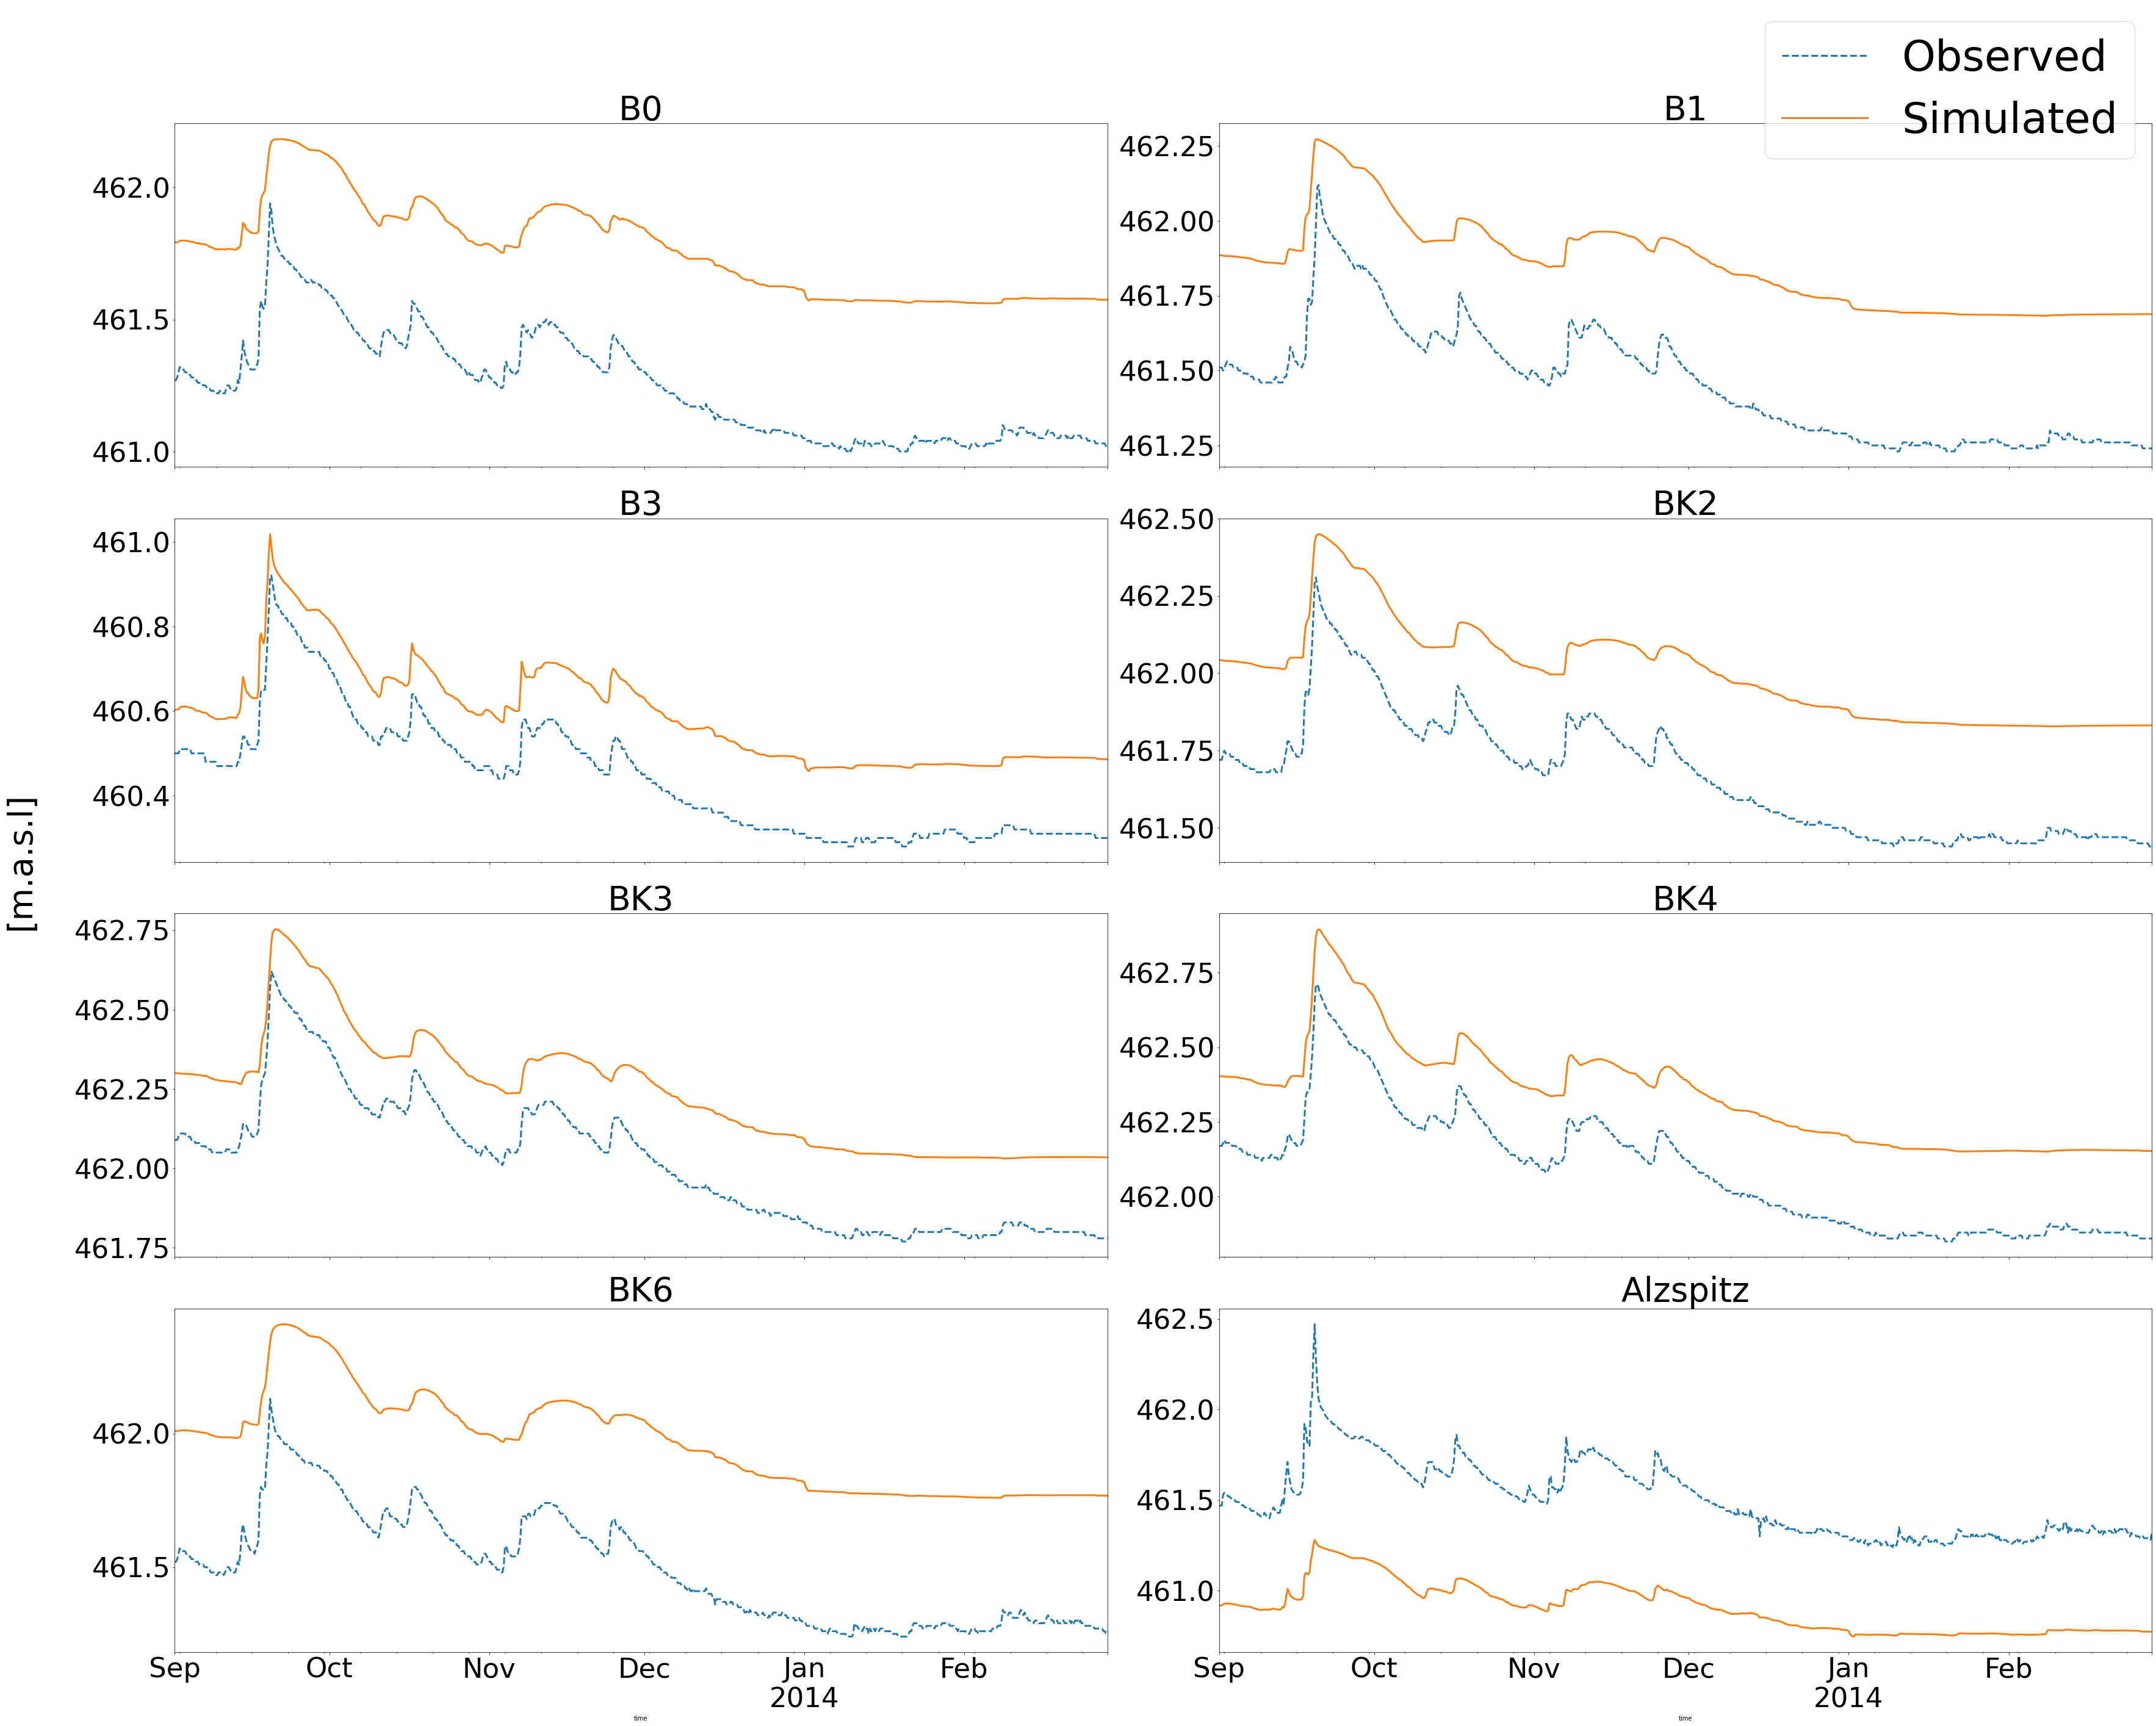

In [41]:
plotss(hobOut, wells)

# Conclusion

The model overstimated almost all the simulated GW levels. However, the relationship is almost linear, so maybe reducing of the the parameter (such as HK) could solve this overshooting. However, observation point *Alzspitz* has an interesting behaviour as it is completely understimated. It is probably not likely to improve while calibrating the other points. Perhaps there is a limitation with this MODFLOW version as discussed in the SFR package. Performing small scales analysis in not possible. Particularly since this well is closely located to the river bank is real life.

# Coming up !! 

* Model calibration (montecarlo)
* The set-up of this model using latest version of MODFLOW to better discretize the stream and, hopefully increase performance!